In [1]:
import sys
import json
import numpy as np
from pathlib import Path
from typing import Dict, List, Set

sys.path.insert(0, str(Path.cwd().parent))
from matching import BibEntry, RefEntry
from matching.common import TextCleaner, FeatureExtractor, OUTPUT_DIR

## 1. Configuration

## Problem Definition

**Task:** Reference Matching - Given a bibliography entry (bibitem) from a LaTeX paper, find the matching arXiv paper from a candidate set.

**Problem Type:** This is a **Ranking Problem** (can also be viewed as Classification)

| Approach | Description | Pros | Cons |
|----------|-------------|------|------|
| **Ranking** | Score each (bib, ref) pair, rank by score, select top-k | Handles multiple candidates naturally | Needs ranking metrics (MRR, NDCG) |
| Classification | Binary classification: match (1) vs non-match (0) | Simple evaluation (accuracy, F1) | Imbalanced classes (few positives) |
| Regression | Predict similarity score [0, 1] | Continuous output | Needs ground truth scores |

**Our Approach:** We use **pairwise ranking with binary classification**:
1. Extract features comparing each (bib, ref) pair
2. Train a classifier to predict match probability
3. Rank candidates by predicted probability
4. Evaluate using MRR@5 (Mean Reciprocal Rank)

In [2]:
# OUTPUT_DIR is imported from common.py
with open(OUTPUT_DIR / 'extracted_data.json', 'r', encoding='utf-8') as f:
    all_data = json.load(f)
print(f"Loaded {len(all_data)} publications")

Loaded 2096 publications


## 2. Feature Extractor

## Feature Design Rationale

For pairwise reference matching, we design features that capture **similarity** between a bibliography entry and a candidate reference:

| Feature | Type | Rationale |
|---------|------|-----------|
| `title_jaccard` | Text | Jaccard similarity of title tokens - robust to word order |
| `title_overlap` | Text | Token overlap ratio - captures partial matches |
| `title_edit_dist` | Text | Normalized edit distance - handles typos/variations |
| `author_overlap` | Author | Overlap of author last names |
| `first_author_match` | Author | First author often most important |
| `year_match` | Metadata | Exact year match (binary) |
| `year_diff` | Metadata | Year difference (continuous) |
| `arxiv_match` | ID | Direct arXiv ID match in bibitem |
| `arxiv_in_content` | ID | arXiv ID appears in raw content |
| `num_matching_authors` | Author | Count of matching authors |
| `title_len_ratio` | Text | Length ratio - filters obvious mismatches |
| `combined_score` | Combined | Weighted combination for initial ranking |

In [3]:
# FeatureExtractor is now imported from common.py
# Display feature names for reference
print("Features used:", FeatureExtractor.FEATURE_NAMES)

Features used: ['title_jaccard', 'title_overlap', 'title_edit_dist', 'author_overlap', 'first_author_match', 'year_match', 'year_diff', 'arxiv_match', 'arxiv_in_content', 'num_matching_authors', 'title_len_ratio', 'combined_score']


## 3. Test Feature Extraction

In [4]:
# Test feature extraction
sample = all_data[0]
bib, ref_key = sample['bibs'][0], list(sample['refs'].keys())[0]
ref = sample['refs'][ref_key]
features = FeatureExtractor.extract_features(bib, ref)

print(f"Pub: {sample['pub_id']}, Bib: {bib['key']}, Ref: {ref_key}")
for name, value in features.items():
    print(f"  {name}: {value:.4f}")

Pub: 2411-00222, Bib: kumar2019failure, Ref: 2006-04182
  title_jaccard: 0.0000
  title_overlap: 0.0000
  title_edit_dist: 0.2432
  author_overlap: 0.0000
  first_author_match: 0.0000
  num_matching_authors: 0.0000
  year_match: 0.0000
  year_diff: 50.0000
  arxiv_match: 0.0000
  arxiv_in_content: 0.0000
  title_len_ratio: 0.5541
  combined_score: 0.0000


## 4. Generate Training Data

In [5]:
def generate_candidate_pairs(pub_data: Dict, max_candidates: int = 50) -> List[Dict]:
    """Generate candidate pairs for a publication"""
    pairs = []
    for bib in pub_data['bibs']:
        candidates = []
        for arxiv_id, ref in pub_data['refs'].items():
            t1 = bib['title'].replace('\n', ' ').strip()
            t2 = ref['title'].replace('\n', ' ').strip()
            if abs(len(t1) - len(t2)) > 40:
                continue
            features = FeatureExtractor.extract_features(bib, ref)
            candidates.append({'pub_id': pub_data['pub_id'], 'bib_key': bib['key'],
                              'arxiv_id': arxiv_id, 'features': features})
        candidates.sort(key=lambda x: x['features']['combined_score'], reverse=True)
        pairs.extend(candidates[:max_candidates])
    return pairs

In [6]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from matching.common import generate_candidate_pairs_worker, FeatureProcessor

num_workers = min(multiprocessing.cpu_count(), 8)
batch_size = 500

print(f"Processing {len(all_data)} publications with {num_workers} workers, batch size {batch_size}")

all_metadata, all_features_list, total_pairs = [], [], 0

for batch_idx in range((len(all_data) + batch_size - 1) // batch_size):
    batch_data = all_data[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    batch_pairs = []
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(generate_candidate_pairs_worker, pub) for pub in batch_data]
        for future in tqdm(as_completed(futures), total=len(batch_data), desc=f"Batch {batch_idx + 1}"):
            batch_pairs.extend(future.result())
    
    all_features_list.append(np.array([[p['features'].get(n, 0.0) for n in FeatureProcessor.FEATURE_NAMES] 
                                        for p in batch_pairs], dtype=np.float32))
    all_metadata.extend([{'pub_id': p['pub_id'], 'bib_key': p['bib_key'], 'arxiv_id': p['arxiv_id'],
                          'combined_score': p['features']['combined_score']} for p in batch_pairs])
    total_pairs += len(batch_pairs)
    print(f"  Batch {batch_idx + 1}: {len(batch_pairs)} pairs, total: {total_pairs}")

# Save results
X = np.vstack(all_features_list)
np.save(OUTPUT_DIR / 'features.npy', X)
with open(OUTPUT_DIR / 'pair_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(all_metadata, f, indent=2)

print(f"\nSaved {X.shape[0]} pairs, feature shape: {X.shape}")

Processing 2096 publications with 8 workers, batch size 500


Batch 1: 100%|██████████| 500/500 [01:08<00:00,  7.30it/s]


  Batch 1: 448875 pairs, total: 448875


Batch 2: 100%|██████████| 500/500 [00:56<00:00,  8.77it/s]


  Batch 2: 444675 pairs, total: 893550


Batch 3: 100%|██████████| 500/500 [01:06<00:00,  7.57it/s]


  Batch 3: 482669 pairs, total: 1376219


Batch 4: 100%|██████████| 500/500 [01:01<00:00,  8.14it/s]


  Batch 4: 438005 pairs, total: 1814224


Batch 5: 100%|██████████| 96/96 [00:18<00:00,  5.09it/s]


  Batch 5: 134116 pairs, total: 1948340

Saved 1948340 pairs, feature shape: (1948340, 12)


## 5. Feature Statistics

In [7]:
print("Feature Statistics:")
for i, name in enumerate(FeatureExtractor.FEATURE_NAMES):
    col = X[:, i]
    print(f"  {name:22s}: mean={col.mean():.3f}, std={col.std():.3f}, min={col.min():.3f}, max={col.max():.3f}")

Feature Statistics:
  title_jaccard         : mean=0.069, std=0.149, min=0.000, max=1.000
  title_overlap         : mean=0.119, std=0.195, min=0.000, max=1.000
  title_edit_dist       : mean=0.260, std=0.126, min=0.000, max=1.000
  author_overlap        : mean=0.016, std=0.104, min=0.000, max=1.000
  first_author_match    : mean=0.007, std=0.085, min=0.000, max=1.000
  year_match            : mean=0.137, std=0.344, min=0.000, max=1.000
  year_diff             : mean=6.126, std=8.910, min=0.000, max=50.000
  arxiv_match           : mean=0.003, std=0.057, min=0.000, max=1.000
  arxiv_in_content      : mean=0.006, std=0.077, min=0.000, max=1.000
  num_matching_authors  : mean=0.060, std=0.463, min=0.000, max=20.000
  title_len_ratio       : mean=0.739, std=0.193, min=0.000, max=1.000
  combined_score        : mean=0.060, std=0.113, min=0.000, max=1.000


---
**Next:** `03_model_training.ipynb`

## 6. Exploratory Data Analysis (EDA)

Visualize feature distributions to understand their discriminative power.

Proxy labels: 17242 positive (0.9%), 1931098 negative


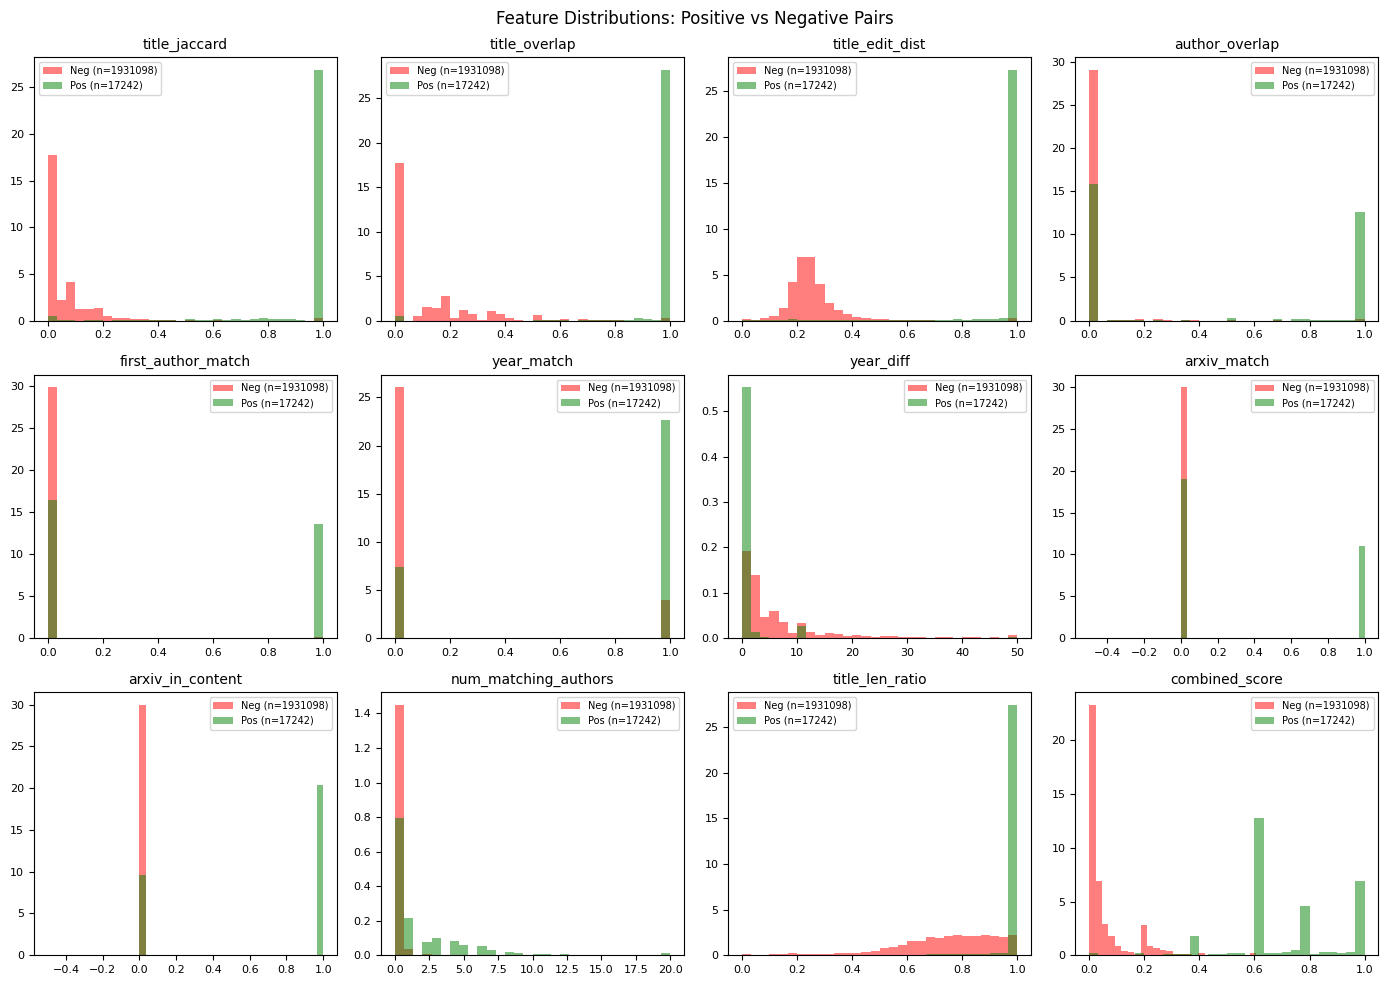

In [8]:
import matplotlib.pyplot as plt

# Create labels based on heuristics (high score = likely match)
# For EDA, we use combined_score > 0.7 or arxiv_match as proxy for positive pairs
y_proxy = ((X[:, 7] == 1.0) | (X[:, 8] == 1.0) | (X[:, 11] > 0.7)).astype(int)
print(f"Proxy labels: {y_proxy.sum()} positive ({100*y_proxy.mean():.1f}%), {len(y_proxy) - y_proxy.sum()} negative")

# Feature distributions for positive vs negative pairs
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()

for i, name in enumerate(FeatureExtractor.FEATURE_NAMES):
    ax = axes[i]
    
    pos_vals = X[y_proxy == 1, i]
    neg_vals = X[y_proxy == 0, i]
    
    ax.hist(neg_vals, bins=30, alpha=0.5, label=f'Neg (n={len(neg_vals)})', density=True, color='red')
    ax.hist(pos_vals, bins=30, alpha=0.5, label=f'Pos (n={len(pos_vals)})', density=True, color='green')
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=7)
    ax.tick_params(labelsize=8)

plt.suptitle('Feature Distributions: Positive vs Negative Pairs', fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'eda_feature_distributions.png', dpi=150)
plt.show()

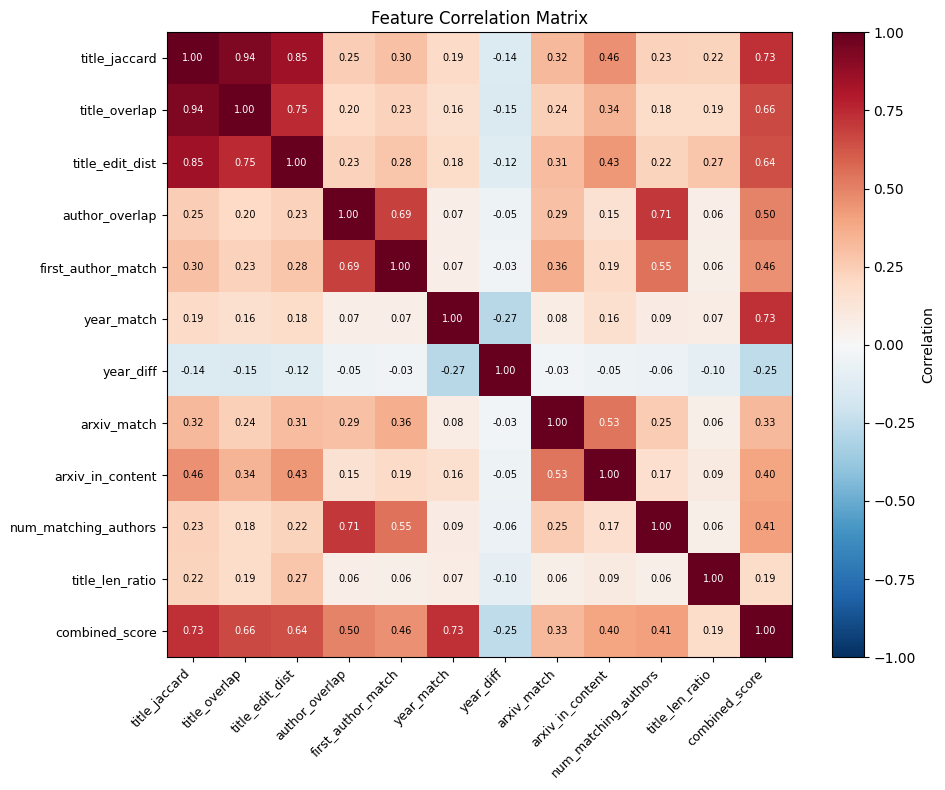

In [9]:
# Feature Correlation Heatmap
correlation_matrix = np.corrcoef(X.T)

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(FeatureExtractor.FEATURE_NAMES)), FeatureExtractor.FEATURE_NAMES, rotation=45, ha='right', fontsize=9)
plt.yticks(range(len(FeatureExtractor.FEATURE_NAMES)), FeatureExtractor.FEATURE_NAMES, fontsize=9)
plt.title('Feature Correlation Matrix')

# Add correlation values
for i in range(len(FeatureExtractor.FEATURE_NAMES)):
    for j in range(len(FeatureExtractor.FEATURE_NAMES)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', fontsize=7,
                color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'eda_correlation_matrix.png', dpi=150)
plt.show()

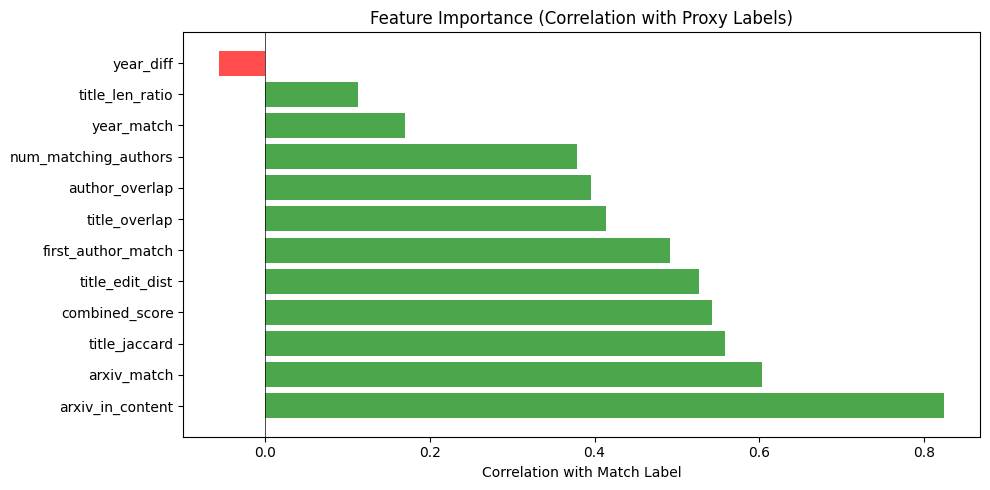


Feature Importance Ranking:
  arxiv_in_content      : corr=+0.8240
  arxiv_match           : corr=+0.6033
  title_jaccard         : corr=+0.5580
  combined_score        : corr=+0.5427
  title_edit_dist       : corr=+0.5269
  first_author_match    : corr=+0.4920
  title_overlap         : corr=+0.4137
  author_overlap        : corr=+0.3961
  num_matching_authors  : corr=+0.3790
  year_match            : corr=+0.1698
  title_len_ratio       : corr=+0.1126
  year_diff             : corr=-0.0554


In [10]:
# Feature Importance Analysis (using correlation with proxy label)
feature_importance = []
for i, name in enumerate(FeatureExtractor.FEATURE_NAMES):
    corr = np.corrcoef(X[:, i], y_proxy)[0, 1]
    feature_importance.append((name, abs(corr), corr))

feature_importance.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 5))
names = [f[0] for f in feature_importance]
values = [f[2] for f in feature_importance]
colors = ['green' if v > 0 else 'red' for v in values]

plt.barh(names, values, color=colors, alpha=0.7)
plt.xlabel('Correlation with Match Label')
plt.title('Feature Importance (Correlation with Proxy Labels)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'eda_feature_importance.png', dpi=150)
plt.show()

print("\nFeature Importance Ranking:")
for name, abs_corr, corr in feature_importance:
    print(f"  {name:22s}: corr={corr:+.4f}")

### EDA Insights

**Key Observations:**

1. **High-impact features:**
   - `arxiv_match` and `arxiv_in_content`: Direct ID matches are strongest signals
   - `title_jaccard` and `title_overlap`: Title similarity is highly discriminative
   - `combined_score`: Weighted combination captures multiple signals

2. **Moderate-impact features:**
   - `author_overlap` and `first_author_match`: Author information helps disambiguate
   - `year_match`: Same year is a positive signal

3. **Feature correlations:**
   - `title_jaccard` and `title_overlap` are highly correlated (expected)
   - `arxiv_match` and `arxiv_in_content` are complementary
   - `year_diff` is negatively correlated with match (larger diff = less likely match)

4. **Class imbalance:**
   - Most pairs are negative (non-matches)
   - Positive pairs have distinctly higher values for similarity features

**Conclusion:** The selected features provide good discriminative power for the ranking task.